In [1]:
%pwd

'/Users/john/code/fairness-tales-workshop/notebooks'

In [2]:
%cd ~/code/fairness-tales-workshop/

/Users/john/code/fairness-tales-workshop


In [3]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

# Section 1: Let's train a (very) biased model!

## Imports

In [4]:
import string
from pathlib import Path

import lightgbm as lgb
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# sklearn
from sklearn import (
    dummy,
    ensemble,
    model_selection,
    tree,
)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.inspection import permutation_importance
from sklearn.metrics import balanced_accuracy_score

ROOT = Path()
np.set_printoptions(legacy="1.25")

## Load data

In [5]:
def whitespace_cleaner(s, n=8):
    """Worse I've seen is a CV full of whitespace, n=8 was enough for this."""
    for i in range(n, 0, -1):
        s = s.replace(" " * i, " ")
    return s


def clean_cv_text(text):
    return whitespace_cleaner(
        text.lower()
        .translate(str.maketrans("", "", string.punctuation))
        .replace("•", " ")
        .replace("\n", " ")
        .replace("*", " ")
        .replace("-", " ")
        .replace("—", " "),
    )

In [6]:
df = pd.read_feather(ROOT / "data" / "output" / "resumes.feather").reset_index(drop=True)

df["text"] = df["cv"].apply(clean_cv_text)

df.shape

(400, 9)

## Let's build a (very) biased model!

In [9]:
X = df[["text"]]
y = df["callback"]

In [10]:
vectorizer = CountVectorizer(max_features=200, ngram_range=(1, 2), stop_words="english")

vectorizer.fit(X.text)
X_text = pd.DataFrame(
    vectorizer.transform(X.text).toarray(),
    columns=vectorizer.get_feature_names_out(),
)
X = pd.concat([X.drop(columns="text"), X_text], axis=1)
X.head()

,2010,2014,2018,2020,2021,2022,30,40,accomplishments,actively,...,version,version control,web,web applications,woman,work,work experience,worked,years,years experience
0,2,1,2,0,0,0,1,1,1,2,...,0,0,3,1,0,1,1,0,1,1
1,0,0,0,0,4,0,0,0,0,1,...,1,1,0,0,0,1,1,2,0,0
2,0,0,0,3,1,0,0,0,1,1,...,2,2,0,0,0,1,1,2,0,0
3,0,0,0,3,3,0,0,0,1,1,...,1,1,1,0,0,1,1,1,2,2
4,0,0,0,0,2,2,0,0,0,1,...,1,1,1,1,0,2,1,1,2,2


In [11]:
f"Baseline callback rate is {y.mean():.1%}"

'Baseline callback rate is 41.2%'

## Let's fit a small decision tree for interpretability

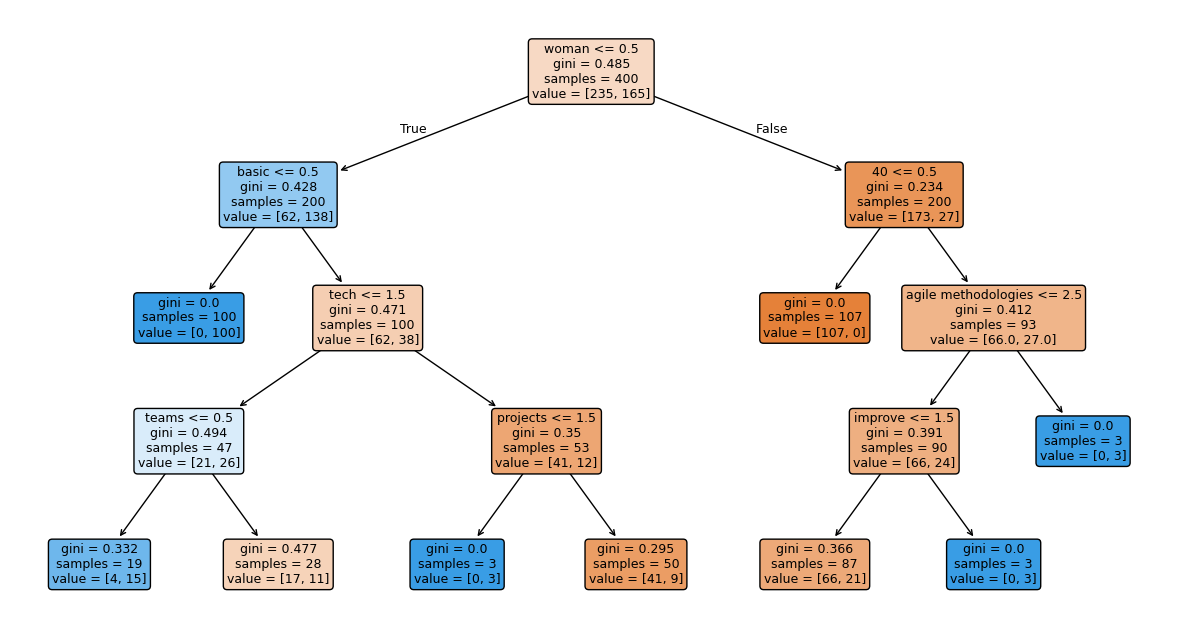

In [14]:
model = tree.DecisionTreeClassifier(max_depth=4)
model = model.fit(X, y)

plt.figure(figsize=(15, 8))
tree.plot_tree(model, feature_names=X.columns, filled=True, rounded=True, fontsize=9);

<Axes: xlabel='sex', ylabel='callback'>

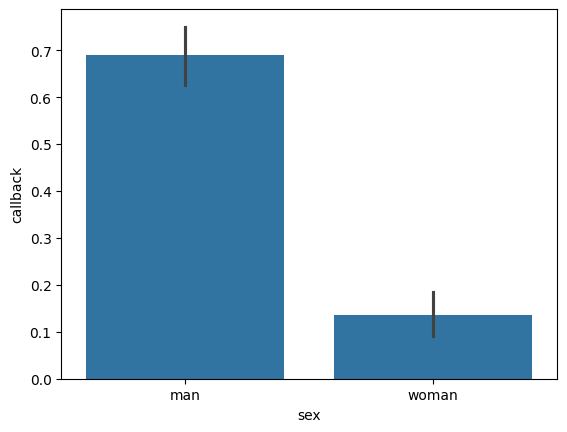

In [15]:
sns.barplot(y=y, x=df.sex)

<Axes: xlabel='aws', ylabel='callback'>

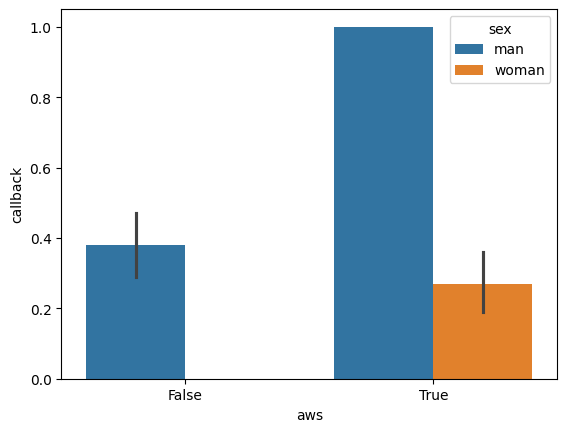

In [16]:
sns.barplot(x=(X.aws > 0), y=y, hue=df.sex)

## Find our next top (biased) model

In [17]:
model_selection.cross_val_score(
    dummy.DummyClassifier(),
    X=X,
    y=y,
    cv=5,
    scoring="accuracy",
).mean()

0.5875

In [18]:
model_selection.cross_val_score(
    ensemble.RandomForestClassifier(n_estimators=100),
    X=X,
    y=y,
    cv=5,
    scoring="accuracy",
).mean()

0.7825

In [19]:
model_selection.cross_val_score(
    tree.DecisionTreeClassifier(),
    X=X,
    y=y,
    cv=5,
    scoring="accuracy",
).mean()

0.7925

In [20]:
model_selection.cross_val_score(
    tree.DecisionTreeClassifier(max_depth=4),
    X=X,
    y=y,
    cv=5,
    scoring="accuracy",
).mean()

0.82

In [21]:
lgb_params = {
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.03,
    "num_leaves": 10,
    "max_depth": 3,
    "n_jobs": 1,
    "verbose": -1,
}

model = lgb.LGBMClassifier(**lgb_params)

model_selection.cross_val_score(
    model,
    X=X,
    y=y,
    cv=5,
    scoring="accuracy",
).mean()

0.8174999999999999

In [22]:
model = lgb.LGBMClassifier(**lgb_params).fit(X, y)

## Interpret the LGBM classifier using permutation importance

In [23]:
r = permutation_importance(model, X, y, n_repeats=30)

<Axes: ylabel='feature'>

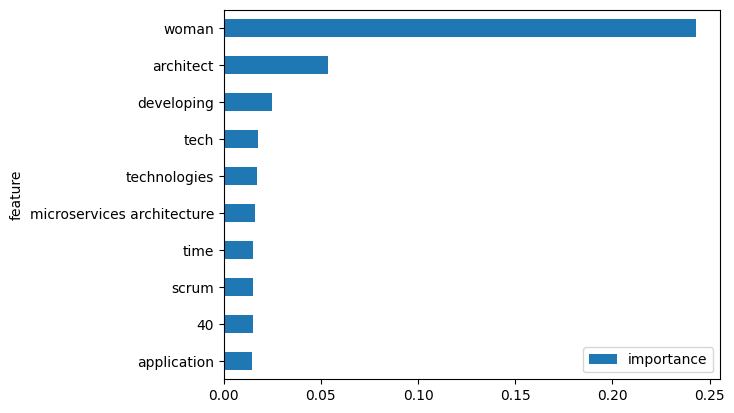

In [24]:
(
    pd.DataFrame({"feature": X.columns, "importance": r["importances_mean"]})
    .sort_values("importance")
    .set_index("feature")
    .tail(10)
    .plot(kind="barh")
)

<Axes: xlabel='architect', ylabel='callback'>

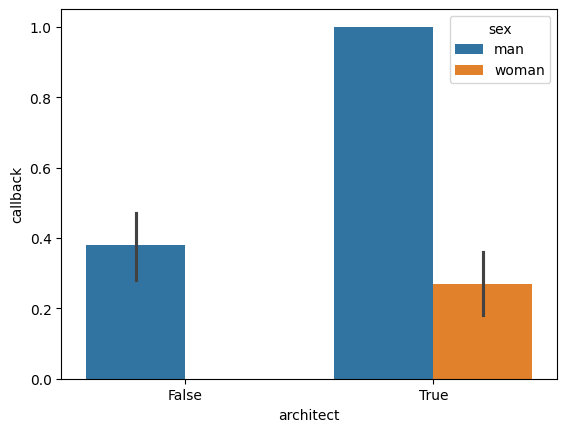

In [25]:
sns.barplot(x=(X["architect"] > 0), y=y, hue=df.sex)

---

# Section 2: Export for Aequitas

In [36]:
aequitas = y.reset_index().rename(columns={"callback": "label_value"}).drop(columns="index")
aequitas["label_value"] = y
aequitas["score"] = model.predict(X)
aequitas["sex"] = df.sex

aequitas.to_csv(ROOT / "data" / "output" / "aequitas.csv", index=False)

---

# Section 3: Intro to Fairlearn

In [37]:
# fairlearn
from fairlearn.metrics import (
    MetricFrame,
    equalized_odds_difference,
    false_negative_rate,
    false_positive_rate,
)
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import EqualizedOdds, ErrorRate, ExponentiatedGradient

## Prepare train, test, and protected characteristics dataframes

In [38]:
A_str = df.sex.astype("category")
A_str.value_counts(normalize=True)

sex
man      0.5
woman    0.5
Name: proportion, dtype: float64

In [39]:
y.value_counts(normalize=True)

callback
0    0.5875
1    0.4125
Name: proportion, dtype: float64

In [40]:
X_train, X_test, y_train, y_test, A_train, A_test = model_selection.train_test_split(
    X,
    y,
    A_str,
    test_size=0.35,
    stratify=y,
)

In [41]:
X_train.shape

(260, 200)

In [42]:
X_test.shape

(140, 200)

## Fit our LGBM model to the training data & generate predictions on test data

In [44]:
model = lgb.LGBMClassifier(**lgb_params)
model.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', n_jobs=1,
               num_leaves=10, objective='binary', verbose=-1)

In [45]:
y_pred = model.predict(X_test)

## Evaluate the "raw" unmitigated LGBM model

In [46]:
fairness_metrics = {
    "balanced_accuracy": balanced_accuracy_score,
    "false_positive_rate": false_positive_rate,
    "false_negative_rate": false_negative_rate,
}

In [47]:
mf_unmitigated = MetricFrame(
    metrics=fairness_metrics,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=A_test,
)

In [48]:
mf_unmitigated.overall

balanced_accuracy      0.820437
false_positive_rate    0.048780
false_negative_rate    0.310345
dtype: float64

In [49]:
mf_unmitigated.by_group

,balanced_accuracy,false_positive_rate,false_negative_rate
sex,,,
man,0.803406,0.157895,0.235294
woman,0.563492,0.015873,0.857143


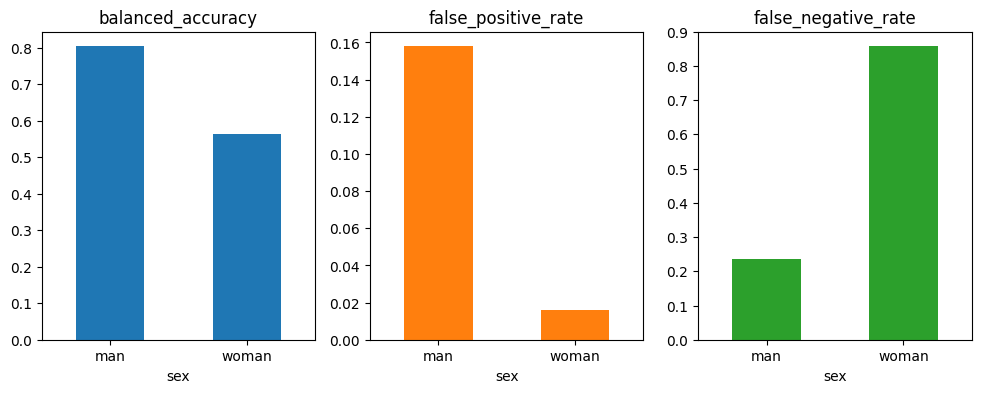

In [52]:
mf_unmitigated.by_group.plot.bar(subplots=True, layout=[1, 3], figsize=[12, 4], legend=None, rot=0);

In [53]:
mf_unmitigated.difference()

balanced_accuracy      0.239914
false_positive_rate    0.142022
false_negative_rate    0.621849
dtype: float64

In [54]:
balanced_accuracy_unmitigated = balanced_accuracy_score(y_test, y_pred)
balanced_accuracy_unmitigated

0.8204373423044575

In [55]:
equalized_odds_unmitigated = equalized_odds_difference(y_test, y_pred, sensitive_features=A_test)
equalized_odds_unmitigated

0.6218487394957983

## Mitigate using post-processing techniques (ThresholdOptimizer)

In [56]:
postprocess_mitigator = ThresholdOptimizer(
    estimator=model,
    constraints="equalized_odds",  # Optimize FPR and FNR simultaneously
    objective="balanced_accuracy_score",
    prefit=True,
    predict_method="predict_proba",
)

In [57]:
postprocess_mitigator.fit(X=X_train, y=y_train, sensitive_features=A_train)
y_pred_postprocess = postprocess_mitigator.predict(X_test, sensitive_features=A_test)

In [58]:
mf_postprocess = MetricFrame(
    metrics=fairness_metrics,
    y_true=y_test,
    y_pred=y_pred_postprocess,
    sensitive_features=A_test,
)
mf_postprocess.overall

balanced_accuracy      0.797519
false_positive_rate    0.146341
false_negative_rate    0.258621
dtype: float64

In [59]:
mf_postprocess.by_group

,balanced_accuracy,false_positive_rate,false_negative_rate
sex,,,
man,0.796698,0.210526,0.196078
woman,0.579365,0.126984,0.714286


array([[<Axes: title={'center': 'balanced_accuracy'}, xlabel='sex'>,
        <Axes: title={'center': 'false_positive_rate'}, xlabel='sex'>,
        <Axes: title={'center': 'false_negative_rate'}, xlabel='sex'>]],
      dtype=object)

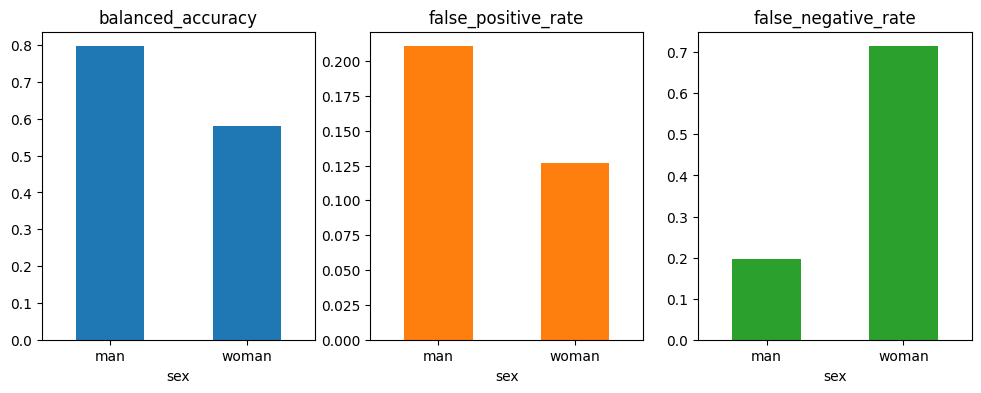

In [60]:
mf_postprocess.by_group.plot.bar(subplots=True, layout=[1, 3], figsize=[12, 4], legend=None, rot=0)

In [61]:
mf_postprocess.difference()

balanced_accuracy      0.217333
false_positive_rate    0.083542
false_negative_rate    0.518207
dtype: float64

In [62]:
balanced_accuracy_postprocess = balanced_accuracy_score(y_test, y_pred_postprocess)
balanced_accuracy_postprocess

0.7975189234650968

In [63]:
equalized_odds_postprocess = equalized_odds_difference(
    y_test,
    y_pred_postprocess,
    sensitive_features=A_test,
)
equalized_odds_postprocess

0.5182072829131653

## Mitigate using Fairlearn Reductions

In [64]:
objective = ErrorRate(costs={"fp": 0.1, "fn": 0.9})
constraint = EqualizedOdds(difference_bound=0.01)
reduction_mitigator = ExponentiatedGradient(model, constraint, objective=objective)
reduction_mitigator.fit(X_train, y_train, sensitive_features=A_train)

ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.EqualizedOdds object at 0x16c4359a0>,
                      estimator=LGBMClassifier(learning_rate=0.03, max_depth=3,
                                               metric='auc', n_jobs=1,
                                               num_leaves=10,
                                               objective='binary', verbose=-1),
                      nu=0.01251612471203543,
                      objective=<fairlearn.reductions._moments.error_rate.ErrorRate object at 0x16c6d7200>)

In [65]:
y_pred_reduction = reduction_mitigator.predict(X_test)

In [67]:
mf_reduction = MetricFrame(
    metrics=fairness_metrics,
    y_true=y_test,
    y_pred=y_pred_reduction,
    sensitive_features=A_test,
)
mf_reduction.overall

balanced_accuracy      0.766821
false_positive_rate    0.414634
false_negative_rate    0.051724
dtype: float64

In [69]:
mf_reduction.by_group

,balanced_accuracy,false_positive_rate,false_negative_rate
sex,,,
man,0.681115,0.578947,0.058824
woman,0.817460,0.365079,0.000000


array([[<Axes: title={'center': 'balanced_accuracy'}, xlabel='sex'>,
        <Axes: title={'center': 'false_positive_rate'}, xlabel='sex'>,
        <Axes: title={'center': 'false_negative_rate'}, xlabel='sex'>]],
      dtype=object)

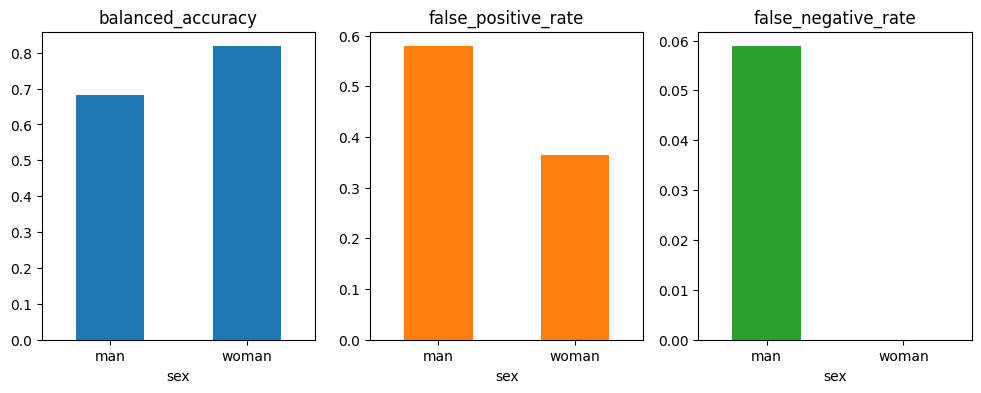

In [70]:
mf_reduction.by_group.plot.bar(subplots=True, layout=[1, 3], figsize=[12, 4], legend=None, rot=0)

In [71]:
mf_reduction.difference()

balanced_accuracy      0.136346
false_positive_rate    0.213868
false_negative_rate    0.058824
dtype: float64

In [72]:
balanced_accuracy_reduction = balanced_accuracy_score(y_test, y_pred_reduction)
balanced_accuracy_reduction

0.766820857863751

In [73]:
equalized_odds_reduction = equalized_odds_difference(
    y_test,
    y_pred_reduction,
    sensitive_features=A_test,
)
equalized_odds_reduction

0.2138680033416876

## Compare our three models

In [74]:
mf_unmitigated.by_group

,balanced_accuracy,false_positive_rate,false_negative_rate
sex,,,
man,0.803406,0.157895,0.235294
woman,0.563492,0.015873,0.857143


In [75]:
mf_postprocess.by_group

,balanced_accuracy,false_positive_rate,false_negative_rate
sex,,,
man,0.796698,0.210526,0.196078
woman,0.579365,0.126984,0.714286


In [76]:
mf_reduction.by_group

,balanced_accuracy,false_positive_rate,false_negative_rate
sex,,,
man,0.681115,0.578947,0.058824
woman,0.817460,0.365079,0.000000


In [77]:
print(
    f"""
{balanced_accuracy_unmitigated=}
{balanced_accuracy_postprocess=}
{balanced_accuracy_reduction=}
""",
)


balanced_accuracy_unmitigated=0.8204373423044575
balanced_accuracy_postprocess=0.7975189234650968
balanced_accuracy_reduction=0.766820857863751



In [78]:
print(
    f"""
{equalized_odds_unmitigated=}
{equalized_odds_postprocess=}
{equalized_odds_reduction=}
""",
)


equalized_odds_unmitigated=0.6218487394957983
equalized_odds_postprocess=0.5182072829131653
equalized_odds_reduction=0.2138680033416876



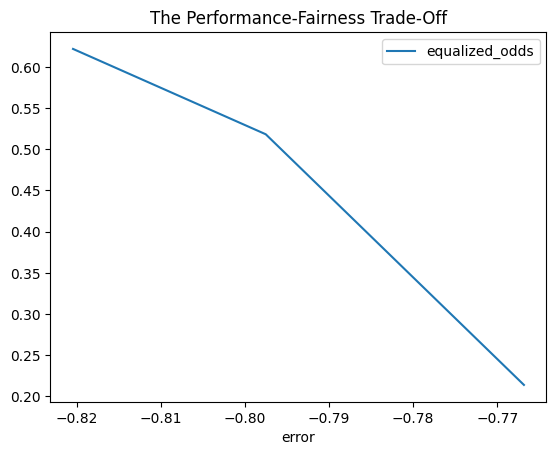

In [79]:
pd.DataFrame(
    {
        "error": [
            -balanced_accuracy_unmitigated,
            -balanced_accuracy_postprocess,
            -balanced_accuracy_reduction,
        ],
        "equalized_odds": [
            equalized_odds_unmitigated,
            equalized_odds_postprocess,
            equalized_odds_reduction,
        ],
    },
).plot(x="error", y="equalized_odds", title="The Performance-Fairness Trade-Off");